# Data (.mat files) loading processing

The Idea is to load the data from the .mat files and convert them into a pandas dataframe. The data is then saved as a pickle file for further use.

Besides this conversion, we have to process the raw subject-specific EEG data and separate it to the domains (classes).

`TODO`: 

+ Hacer una ppt del paper que referencia a CHATRIN

+ Terminar de compilar la stargan-ssvep

In [1]:
# import the neccesary libraries to read mat files
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os
import glob
import re
import pickle
import time
import datetime
import math
import random
import warnings
warnings.filterwarnings('ignore')

## Description of the dataset:


This dataset gathered SSVEP-BCI recordings of 35 healthy subjects (17 females, aged 17-34 years, mean age: 22 years) focusing on 40 characters flickering at different frequencies (8-15.8 Hz with an interval of 0.2 Hz). For each subject, the experiment consisted of 6 blocks. Each block contained 40 trials corresponding to all 40 characters indicated in a random order. Each trial started with a visual cue (a red square) indicating a target stimulus. The cue appeared for 0.5 s on the screen. Subjects were asked to shift their gaze to the target as soon as possible within the cue duration. Following the cue offset, all stimuli started to flicker on the screen concurrently and lasted 5 s. After stimulus offset, the screen was blank for 0.5 s before the next trial began, which allowed the subjects to have short breaks between consecutive trials. Each trial lasted a total of 6 s. To facilitate visual fixation, a red triangle appeared below the flickering target during the stimulation period. In each block, subjects were asked to avoid eye blinks during the stimulation period. To avoid visual fatigue, there was a rest for several minutes between two consecutive blocks.

EEG data were acquired using a Synamps2 system (Neuroscan, Inc.) with a sampling rate of 1000 Hz. The amplifier frequency passband ranged from 0.15 Hz to 200 Hz. Sixty-four channels covered the whole scalp of the subject and were aligned according to the international 10-20 system. The ground was placed on midway between Fz and FPz. The reference was located on the vertex. Electrode impedances were kept below 10 KΩ. To remove the common power-line noise, a notch filter at 50 Hz was applied in data recording. Event triggers generated by the computer to the amplifier and recorded on an event channel synchronized to the EEG data. 


The continuous EEG data was segmented into 6 s epochs (500 ms pre-stimulus, 5.5 s post-stimulus onset). The epochs were subsequently downsampled to 250 Hz. Thus each trial consisted of 1250 time points. Finally, these data were stored as double-precision floating-point values in MATLAB and were named as subject indices (i.e., S01.mat, …, S35.mat). For each file, the data loaded in MATLAB generate a 4-D matrix named ‘data’ with dimensions of [64, 1250, 40, 6]. The four dimensions indicate ‘Electrode index’, ‘Time points’, ‘Target index’, and ‘Block index’. The electrode positions were saved in a ‘64-channels.loc’ file. Six trials were available for each SSVEP frequency. Frequency and phase values for the 40 target indices were saved in a ‘Freq_Phase.mat’ file.


+ Each trial lasted a total of 6 s.

+ Each trial consisted of 1250 time points.

+ There were 6 blocks. Thus, 6 trials for each SSVEP frequency. (9000 time points for each SSVEP frequency)

+ The total time for each SSVEP frequency was 6*6 = 36 s.

The frequency and phase values are used to generate the SSVEP stimuli. The stimuli are generated by the following equation:

$$
x(t) = sin(2\pi f t + \phi)
$$

where $f$ is the frequency and $\phi$ is the phase value.


In [2]:
# Path: core\utils.py
# read a mat file and return the data
def read_mat_file(file_path):
    data = sio.loadmat(file_path)
    return data


def read_mat_file_as_df(file_path, columns):
    data = read_mat_file(file_path)
    data_values = data['data']
    
    data_values = data_values[:, 125:(1250 + 125), :, :]
    
    data_values = data_values.reshape((64, 1250*40*6))
    data_labels = np.array([i for i in range(40) for j in range(6) for k in range(1250)])
    data_df = pd.DataFrame(data_values.T)
    data_df.columns = ["FP1", "FPZ", "FP2", "AF3", "AF4", "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "M1", "TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8", "M2", "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "CB1", "O1", "Oz", "O2", "CB2"]
    data_df['labels'] = data_labels

    if columns is not None:
        data_df = data_df[columns + ['labels']]
    return data_df



(64, 1500, 40, 6)
(4, 1250)


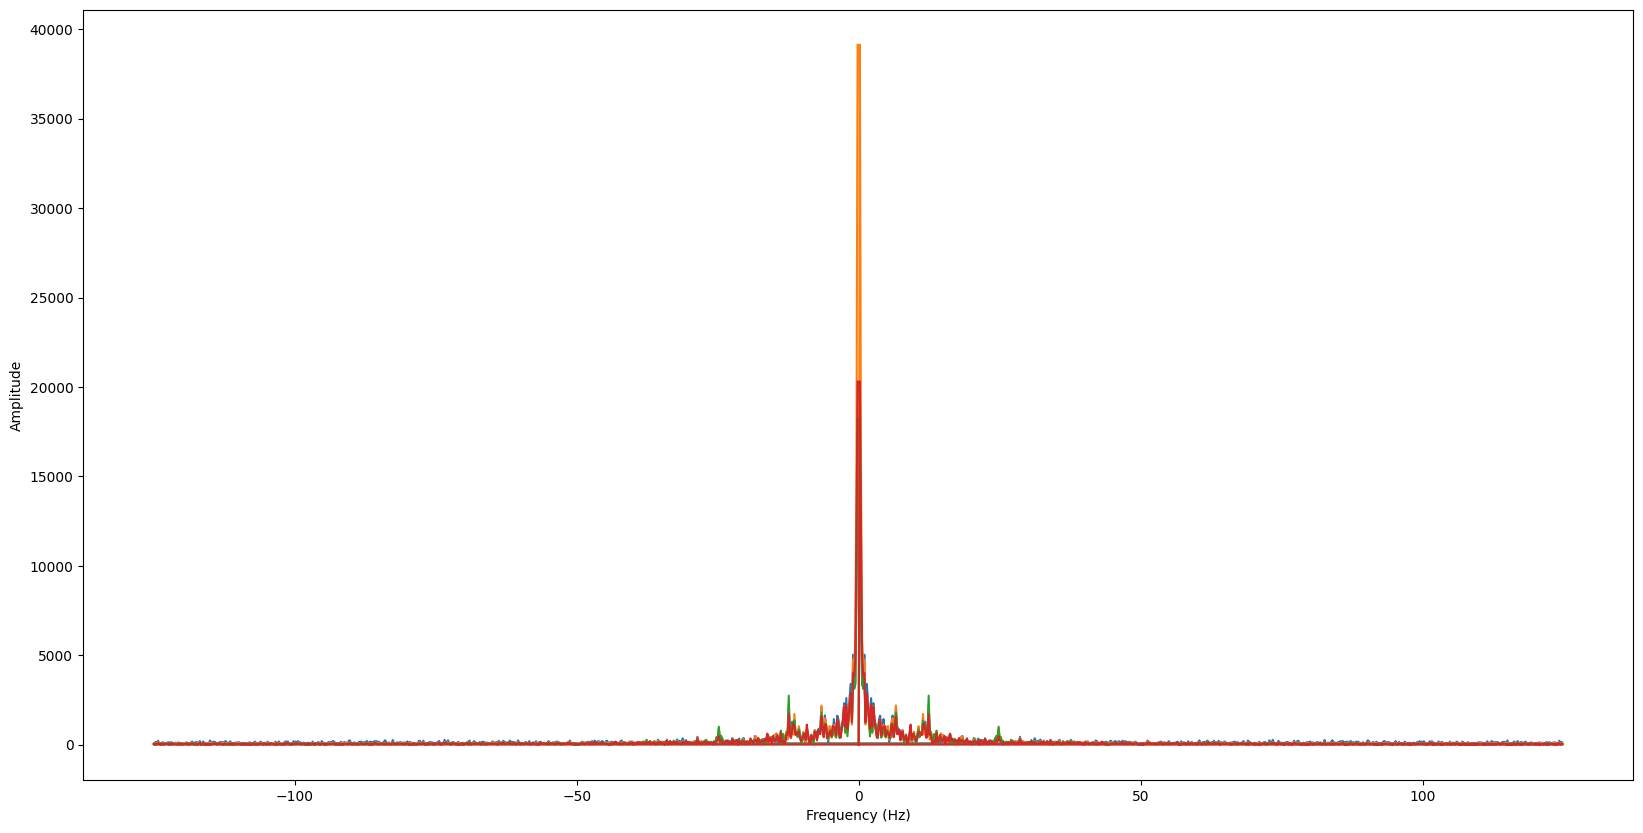

In [26]:

# Test the function with the path ".\data\raw\S3.mat"
data = read_mat_file("../data/raw/S3.mat")
print(data['data'].shape)
sample = data['data'][-5:-1, 125:(1250 + 125), 20, 0]
print(sample.shape)

# sample has a shape of (3, 1250): 3 electrodes (channels) and 1250 time steps, plot it
# plot each channel on a subplot
# fig, ax = plt.subplots(sample.shape[0], 1, figsize=(20, 10))
# for i in range(sample.shape[0]):
#     ax[i].plot(sample[i])
#     ax[i].set_title("Channel {}".format(i + 1))
# plt.show()

# sample = sample - np.mean(sample, axis=1, keepdims=True)
# Now plot the frequency spectrum of the sample
# use a fft to get the frequency spectrum
sample_fft = np.fft.fft(sample)
# get the absolute value of the fft
sample_fft = np.abs(sample_fft)
# get the frequency values
freqs = np.fft.fftfreq(sample.shape[1], 1 / 250)
# plot the frequency spectrum
plt.figure(figsize=(20, 10))
plt.plot(freqs, sample_fft.T)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
data_fre = read_mat_file("../data/raw/Freq_Phase.mat")
print(data_fre['phases'].shape)
print(data_fre['freqs'].shape)
print(data_fre['freqs'])
print(data_fre['phases'])

(1, 40)
(1, 40)
[[ 8.   9.  10.  11.  12.  13.  14.  15.   8.2  9.2 10.2 11.2 12.2 13.2
  14.2 15.2  8.4  9.4 10.4 11.4 12.4 13.4 14.4 15.4  8.6  9.6 10.6 11.6
  12.6 13.6 14.6 15.6  8.8  9.8 10.8 11.8 12.8 13.8 14.8 15.8]]
[[0.         1.57079633 3.14159265 4.71238898 0.         1.57079633
  3.14159265 4.71238898 1.57079633 3.14159265 4.71238898 0.
  1.57079633 3.14159265 4.71238898 0.         3.14159265 4.71238898
  0.         1.57079633 3.14159265 4.71238898 0.         1.57079633
  4.71238898 0.         1.57079633 3.14159265 4.71238898 0.
  1.57079633 3.14159265 0.         1.57079633 3.14159265 4.71238898
  0.         1.57079633 3.14159265 4.71238898]]


In [18]:
def read_all_mat_files_and_save_as_csv(columns=None, labels = None):
    for i in range(1, 36):
        file_path = "../data/raw/S" + str(i) + ".mat"
        data_df = read_mat_file_as_df(file_path, columns)

        if labels is not None:
            # Return only the data with a label in the labels list
            data_df = data_df[data_df['labels'].isin(labels)]
            
        data_df.to_csv("../data/processed/S" + str(i) + ".csv", index=False)

read_all_mat_files_and_save_as_csv(["O1", "Oz", "O2"], [2, 4])

Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4    7500
Name: count, dtype: int64
Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4    7500
Name: count, dtype: int64
Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4    7500
Name: count, dtype: int64
Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4    7500
Name: count, dtype: int64
Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4    7500
Name: count, dtype: int64
Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4    7500
Name: count, dtype: int64
Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4    7500
Name: count, dtype: int64
Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4    7500
Name: count, dtype: int64
Before part: (64, 1500, 40, 6)
After part:  (64, 1250, 40, 6)
labels
2    7500
4

In [10]:
df_S1 = pd.read_csv('./data/processed/S10.csv')

df_S1 = df_S1[df_S1['labels'] == 2]
print(df_S1.shape)
df_S1.head()

# The signal has a total of 9000 samples, 36 seconds of total duration, 1250 samples per trial, 6 trials per class
# We have to segment the signal into 1.2 seconds windows, so we will have 100 windows per trial.

# Path: core\utils.py
def segment_signal_into_windows(df, window_size):
    N = df.shape[0]
    dim = df.shape[1]
    K = int(N/window_size)
    segments = np.empty((K, window_size, dim))
    
    for i in range(K):
        segment = df[i*window_size : i*window_size+window_size,:]
        segments[i] = np.vstack(segment)
    return segments

# Path: core\utils.py
def segment_signal_into_overlapping_windows(df, window_size, overlap):
    N = df.shape[0]
    dim = df.shape[1]
    K = int(N/window_size)
    segments = np.empty((K, window_size, dim))
    for i in range(K):
        segment = df[i*overlap : i*overlap+window_size,:]
        segments[i] = np.vstack(segment)
    return segments

# Now, create a bandpass filter to filter the signal between 2 and 54 Hz
# Use a butterworth filter of order 6
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = float(lowcut) / nyq
    high = float(highcut) / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

# Path: core\utils.py
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=0)
    return y

# Path: core\utils.py
def apply_filter_to_segments(segments, lowcut, highcut, fs, order=6, segment_dim=1250):
    N = segments.shape[0]
    dim = segments.shape[2]
    filtered_segments = np.empty((N, segment_dim, dim))
    for i in range(N):
        segment = segments[i]
        filtered_segments[i] = butter_bandpass_filter(segment, lowcut, highcut, fs, order=order)
    return filtered_segments

# Path: core\utils.py
def apply_filter_to_signal(signal, lowcut, highcut, fs, order=6):
    dim = signal.shape[1]
    filtered_signal = np.empty((signal.shape[0], dim))
    filtered_signal = butter_bandpass_filter(signal, lowcut, highcut, fs, order=order)
    return filtered_signal

# Path: core\utils.py
def apply_filter_to_df(df, lowcut, highcut, fs, order=6):
    dim = df.shape[1]
    filtered_df = np.empty((df.shape[0], dim))
    filtered_df = butter_bandpass_filter(df, lowcut, highcut, fs, order=order)
    return filtered_df

# Path: core\utils.py
def apply_filter_to_df_with_labels(df, lowcut, highcut, fs, order=6):
    dim = df.shape[1]
    filtered_df = np.empty((df.shape[0], dim))
    filtered_df = butter_bandpass_filter(df, lowcut, highcut, fs, order=order)
    filtered_df['labels'] = df['labels']
    return filtered_df


# segments = segment_signal_into_windows(df_S1.drop('labels', axis = 1).values, 1250)
# filtered_segments = apply_filter_to_segments(segments, 2, 54, 250, order=6)

# Path: core\utils.py
# For each subject (.csv with 4 columns, the 3 first are the channels and the last one the label), segment the signal into 1.2 seconds windows, then apply a bandpass filter between 2 and 54 Hz.
# The src dir is ..data/processed, the target dir is ..data/final

def segment_and_filter_all_subjects(src_dir, target_dir, window_size, lowcut, highcut, fs, order=6):
    # save the segments on the target dir / label name
    df = pd.read_csv(os.path.join(src_dir, "S1.csv"))
    labels = df['labels'].unique()
    for label in labels:
        label_dir = os.path.join(target_dir, str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        
        for i in range(1, 36):
            file_path = os.path.join(src_dir, "S" + str(i) + ".csv")
            df = pd.read_csv(file_path)
            df = df[df['labels'] == label]
            segments = segment_signal_into_windows(df.drop('labels', axis = 1).values, window_size)
            filtered_segments = apply_filter_to_segments(segments, lowcut, highcut, fs, order=order, segment_dim=window_size)
            for j in range(filtered_segments.shape[0]):
                segment = filtered_segments[j]

                if segment.shape[0] == window_size:
                    np.save(os.path.join(label_dir, "S" + str(i) + "_" + str(j) + ".npy"), segment)
                else:
                    print("segment with shape " + str(segment.shape) + " not saved")


# segment_and_filter_all_subjects("../data/processed", "../data/final", 256, 2, 54, 250, order=6)


(7500, 4)


In [23]:
# now we have the final data. next, we split it onto train and validation sets (each one in its directory, data/train,  data/val)
# Path: core\utils.py

def split_data(src_dir, target_dir, train_size):
    labels = os.listdir(src_dir)
    for label in labels:
        label_dir = os.path.join(src_dir, label)
        files = os.listdir(label_dir)
        train_dir = os.path.join(target_dir, "train", label)
        val_dir = os.path.join(target_dir, "val", label)
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(val_dir):
            os.makedirs(val_dir)
        for i in range(len(files)):
            file = files[i]
            if i < train_size*len(files):
                shutil.copy(os.path.join(label_dir, file), os.path.join(train_dir, file))
            else:
                shutil.copy(os.path.join(label_dir, file), os.path.join(val_dir, file))

split_data("../data/final", "../data", 0.84)

In [47]:
filtered_segments.shape

(6, 1250, 3)

In [50]:
# load a sample output file
sample = np.load("../data/final/2/S1_0.npy")

sample.shape

(256, 3)

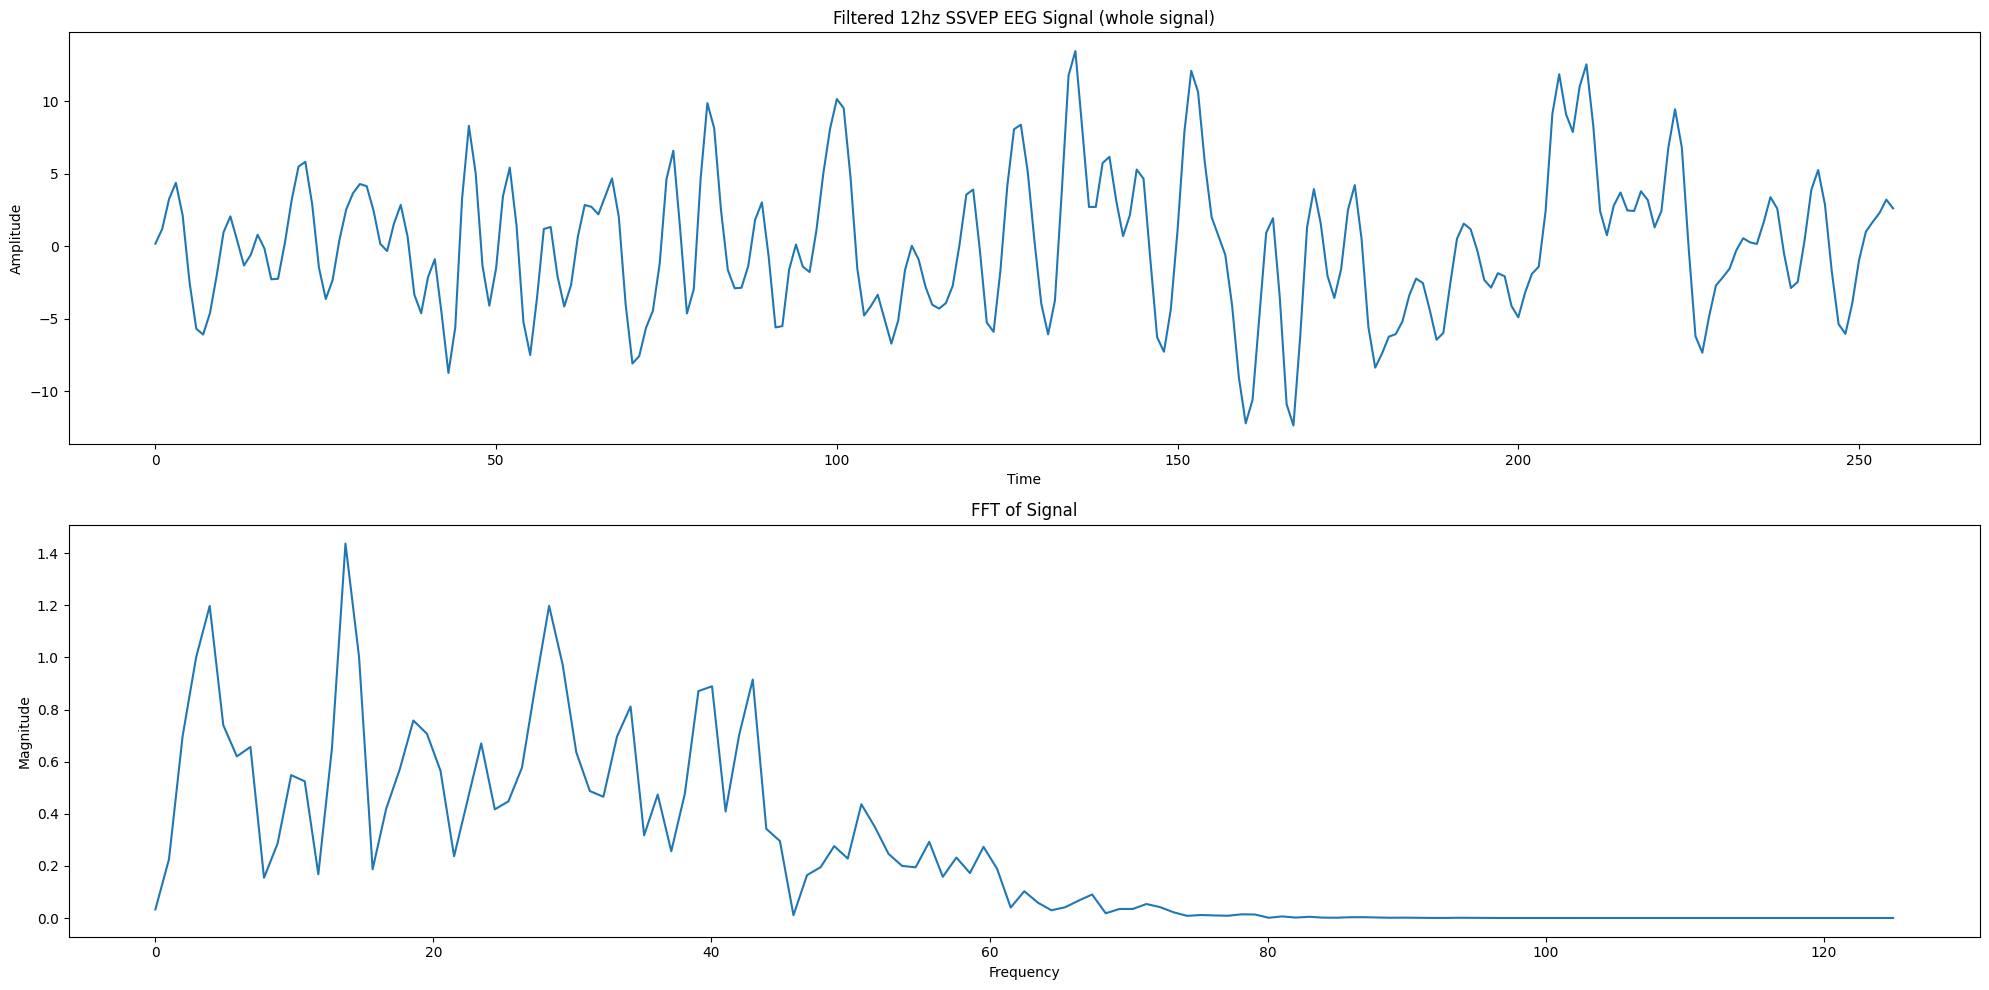

In [52]:
data = sample[:, 0].flatten()

# plot the EEG data and its fft
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.plot(data)
plt.title('Filtered 12hz SSVEP EEG Signal (whole signal)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plt.magnitude_spectrum(data, Fs=250)
plt.title('FFT of Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'O2')

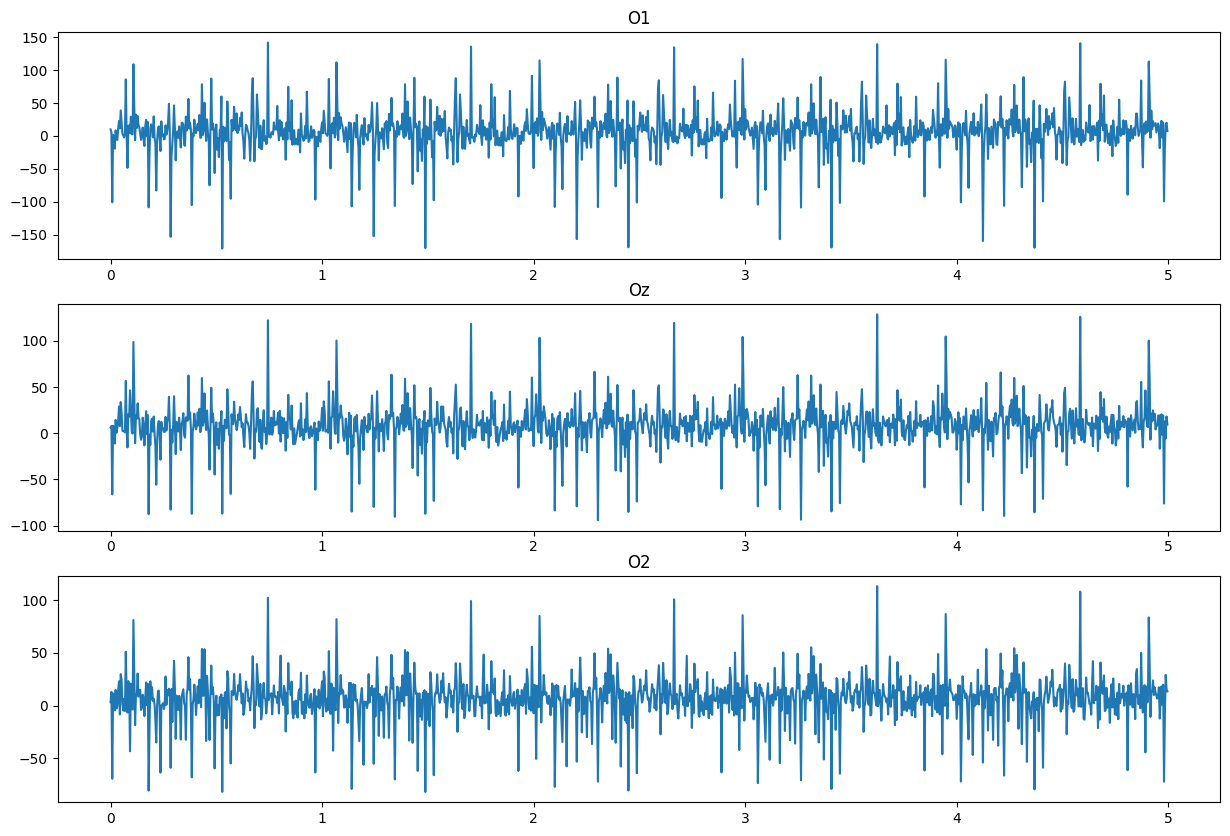

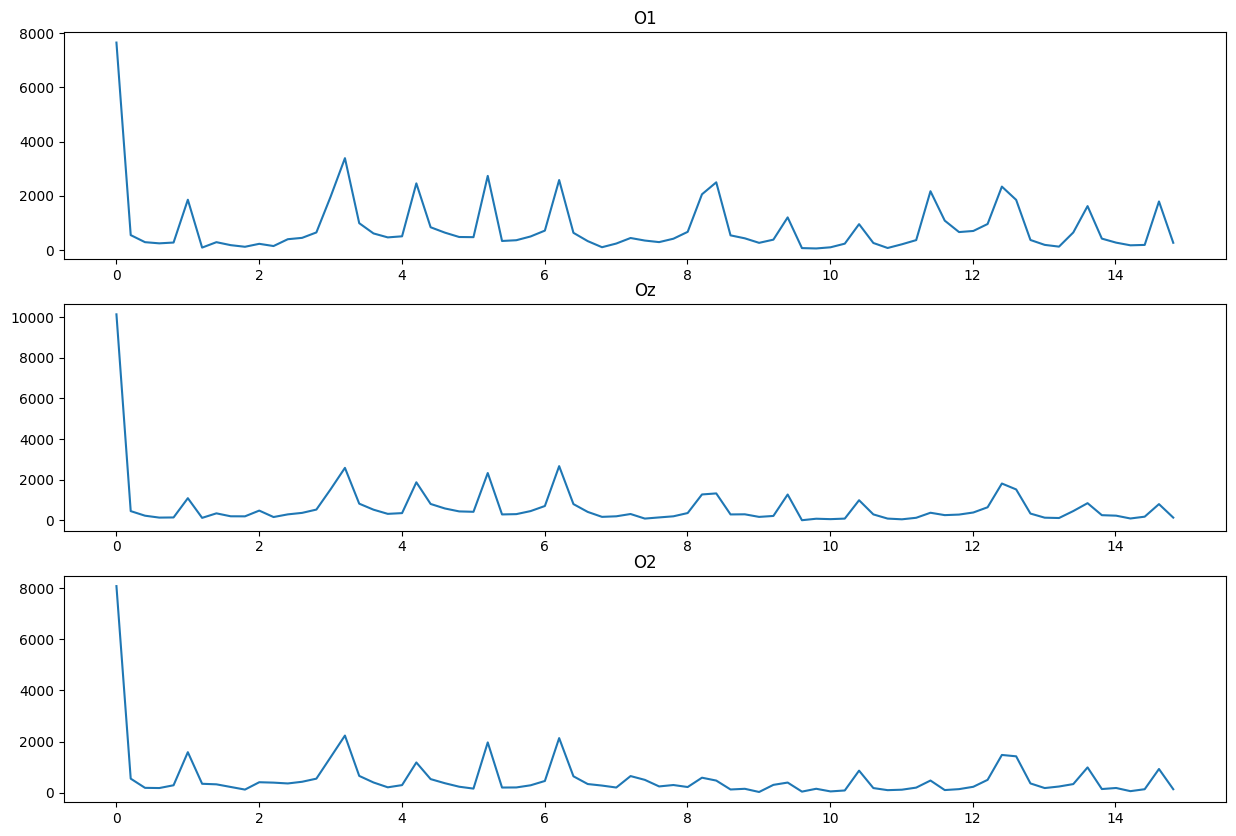

In [45]:

# TODO: De los 6 segundos que dura cada senial, usar solo los 5 del medio (obviar 0.5 segundos al inicio y al final)

# Plot the fft of each electrode (O1, Oz, O2) for the first trial (first 1500 samples)
Fs = 250
T = 1/Fs
L = 1250
t = np.arange(0, L/Fs, T)
f = np.linspace(0, Fs, L)

fig, axs = plt.subplots(3, 1, figsize=(15, 10)) 
axs[0].plot(t, df_S1[['O1']].values[:1250])
axs[0].set_title('O1')
axs[1].plot(t, df_S1[['Oz']].values[:1250])
axs[1].set_title('Oz')
axs[2].plot(t, df_S1[['O2']].values[:1250])
axs[2].set_title('O2')

fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].plot(f[:75], np.abs(np.fft.fft(df_S1[['O1']].values[:1250].reshape(1250)))[:75])
axs[0].set_title('O1')
axs[1].plot(f[:75], np.abs(np.fft.fft(df_S1[['Oz']].values[:1250].reshape(1250)))[:75])
axs[1].set_title('Oz')
axs[2].plot(f[:75], np.abs(np.fft.fft(df_S1[['O2']].values[:1250].reshape(1250)))[:75])
axs[2].set_title('O2')

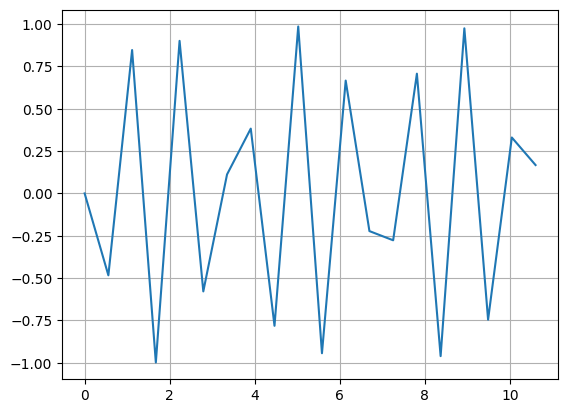

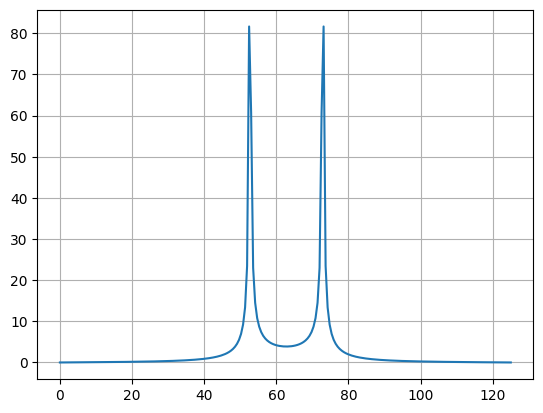

In [129]:
data = read_mat_file("../data/raw/S1.mat")
print(data['data'].shape)

(64, 1500, 40, 6)


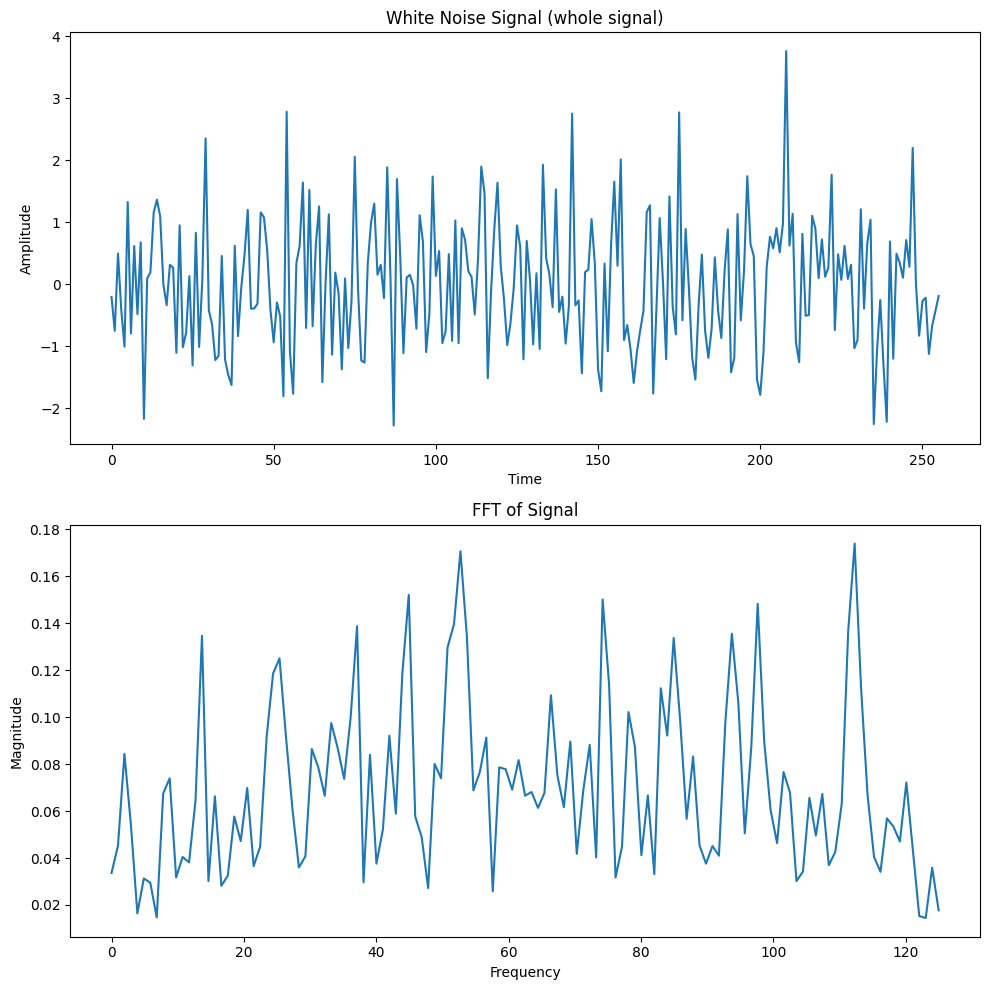

In [7]:
# generate 256 samples of white noise
noise = np.random.normal(0, 1, 256)

# plot the noise and its fft
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(noise)
plt.title('White Noise Signal (whole signal)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plt.magnitude_spectrum(noise, Fs=250)
plt.title('FFT of Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

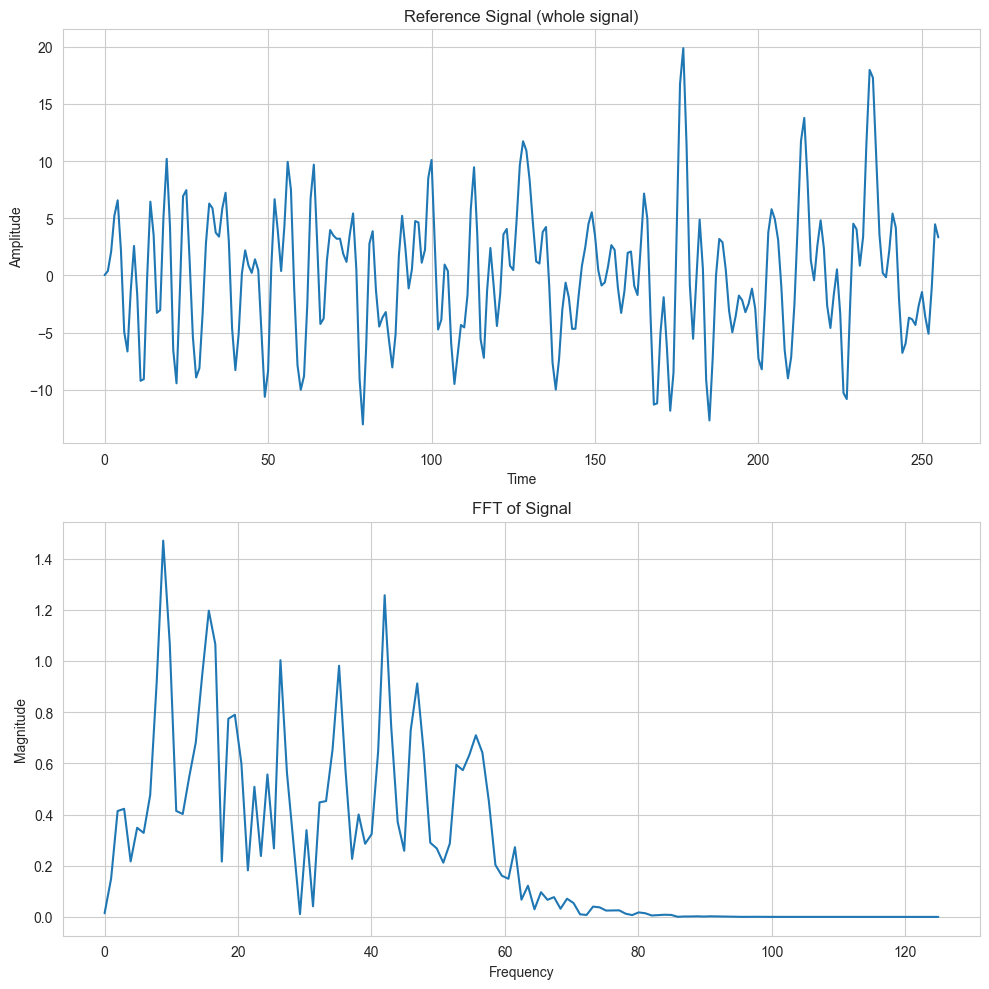

In [31]:
# load a sample output file
sample = np.load("./data/val/1/S4_21.npy")

# plot the first channel (256, 0) of the signal
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(sample[:, 0])
plt.title('Reference Signal (whole signal)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plt.magnitude_spectrum(sample[:, 0], Fs=250)
plt.title('FFT of Signal')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

In [29]:
filtered = apply_filter_to_signal(sample, 6, 20, 250, order=6)

# plot the first channel (256, 0) of the signal
plt.figure(figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [41]:
# exponential moving average
def exp_moving_avg(signal, alpha):
    ema = np.zeros(signal.shape)
    ema[0] = signal[0]
    for i in range(1, signal.shape[0]):
        ema[i] = alpha*signal[i] + (1-alpha)*ema[i-1]
    return ema

In [ ]:
# get the power spectral density of the filtered signal
# sample = np.load("./data/val/1/S9_3.npy")
# filtered = apply_filter_to_signal(exp_moving_avg(sample, 0.2), 6, 20, 250, order=6)
# psd = np.abs(np.fft.fft(filtered[:, 0].flatten()))

# # get the frequencies until 50Hz of the psd
# psd = psd[:int(len(psd)/5)]

# get the psd of all signals corresponding to the subject 9 (that havet S9*) in ./data/val/1
# Then get the mean of all psd's and plot it
psds = []
for file in os.listdir("./data/train/1"):
    if file.startswith("S2"):
        sample = np.load("./data/train/1/" + file)
        filtered = apply_filter_to_signal(exp_moving_avg(sample, 0.13), 6, 20, 250, order=6)
        psd = np.abs(np.fft.fft(filtered[:, 0].flatten()))
        psd = psd[:int(len(psd)/5)]
        psds.append(psd)
psds = np.array(psds)
mean_psd = np.mean(psds, axis=0)

# use stem to plot the psd
# and the second frequency dot paint it in red
plt.figure(figsize=(10,10))
plt.stem(mean_psd)
plt.stem(10, mean_psd[10], 'r')
plt.stem(20, mean_psd[20], 'r')
plt.stem(30, mean_psd[30], 'r')
plt.title('Power Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()



In [ ]:
plt.stem(psd)
plt.title('Power Spectral Density of Filtered Signal')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(x, data1, color=['#1f77b4', '#ff7f0e'])
plt.title('Precision de los modelos')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [446]:
# precision
data1 = np.array([0.567, 0.574]) # y (values)

# calculate ITR
itr = 60/0.5*(np.log2(4) + data1*np.log2(data1) + (1-data1)*np.log2((1-data1)/3))
print(itr)

[39.20433563 40.8797477 ]
